<a href="https://colab.research.google.com/github/misoc-mml/ncrm-causality-2022/blob/main/labs/part_2/Tutorial_Synth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Inference - Tutorial

We are going to combine our knowledge of regression and classification methods to estimate some causal effects.

Steps we are going to take:
1. Problem description.
2. Importing packages.
3. Loading and exploring the data.
4. Training the models.
5. Performance evaluation.

## Step 1 - problem setting



We use the data generating process (DGP) from [Kunzel et al.](https://arxiv.org/abs/1706.03461) and EconML's [example notebooks](https://github.com/Microsoft/EconML/blob/main/notebooks/Metalearners%20Examples.ipynb). The DGP is described by the following equations:

$
Y = \mu_1(x) \cdot T + \mu_0(x) \cdot (1-T) + \epsilon \\
T \sim Bern(e(x)), \; e(x) = P(T=1|X=x)
$

where 

$
\mu_0(x) = x^T\beta,\; with \;\beta\sim Unif([-3, 3]^d),\; X_i \sim N(0, \Sigma)\\
\mu_1(x) = \mu_0(x) + 8 \mathbb{I}(x_2>0.1) => CATE(x) = 8 \mathbb{I}(x_2>0.1)
$

We generated 1,000 samples with 5 covariates (X), binary treatment (T) and continuous outcome (Y).

In terms of evaluation metrics, we are interested in predicting both individual and average treatment effects for this task. As the outcomes are simulated, we have access to both true outcomes $\mathcal{Y}_1$ and $\mathcal{Y}_0$ for each individual (i). As a result, we have access to true ITEs and true ATE:

$$ITE^{(i)} = \mathcal{Y}_1^{(i)} - \mathcal{Y}_0^{(i)}$$

$$ATE = \mathbb{E}[ITE]$$

We can define our predictions as:

$$\widehat{ITE}^{(i)} = \hat{y}_1^{(i)} - \hat{y}_0^{(i)}$$

$$\widehat{ATE} = \frac{1}{n}\sum \limits_{i=1}^{n}\widehat{ITE}^{(i)}$$

This allows us to define measurement errors with respect to each as:

$$\epsilon_{PEHE} = \sqrt{\frac{1}{n}\sum \limits_{i=1}^{n}(\widehat{ITE}^{(i)} - ITE^{(i)})^2}$$

$$\epsilon_{ATE} = \left| \widehat{ATE} - ATE \right|$$

Where PEHE stands for Precision in Estimation of Heterogeneous Effect, and which essentially is a Root Mean Squared Error (RMSE) between predicted and true ITEs. Implementations of both metrics are provided below.

In [1]:
def rmse(a, b):
    a = a.reshape(-1, 1)
    b = b.reshape(-1, 1)
    return np.sqrt(((a - b)**2).mean())

def ate_error(pred_te, true_te):
  return np.abs(np.mean(pred_te) - np.mean(true_te))

def pehe_error(pred_te, true_te):
  return rmse(true_te, pred_te)

## Step 2 - packages

Google Colab has loads of pre-installed packages already. What if we need more? We can install additional packages by knowing that:
- The exclamation mark ('!') gives us access to the Linux command line that runs behind our notebook.
- We can access the default python's package manager with the command 'pip'.

In our case, we are interested in using the [EconML](https://econml.azurewebsites.net/index.html) package, which is not part of the default Colab environment. We can install it via the following command:

In [2]:
!pip install econml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 6.7 MB/s 
     |████████████████████████████████| 564 kB 35.8 MB/s 
     |████████████████████████████████| 164 kB 53.7 MB/s 
     |████████████████████████████████| 77 kB 6.7 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


Note this command has to be executed everytime you restart the notebook.

Now, we can import anything we need from EconML, together with the rest of the packages we need.

In [3]:
from econml.metalearners import XLearner
from econml.dr import DRLearner
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

## Step 3 - data

We are dealing here with the '.npz' file format. In order to access the data, the file can be either manually uploaded to Colab, or downloaded via the following command:

In [4]:
!wget https://github.com/misoc-mml/ncrm-causality-2022/raw/main/labs/part_2/data/synth_train.npz
!wget https://github.com/misoc-mml/ncrm-causality-2022/raw/main/labs/part_2/data/synth_test.npz

--2022-10-07 15:32:57--  https://github.com/misoc-mml/ncrm-causality-2022/raw/main/labs/part_2/data/synth_train.npz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/misoc-mml/ncrm-causality-2022/main/labs/part_2/data/synth_train.npz [following]
--2022-10-07 15:32:57--  https://raw.githubusercontent.com/misoc-mml/ncrm-causality-2022/main/labs/part_2/data/synth_train.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56724 (55K) [application/octet-stream]
Saving to: ‘synth_train.npz’

synth_train.npz     100%[===================>]  55.39K  --.-KB/s    in 0.007s  

2022-10-07 15:32:57 (8.21 MB/s) -

Let's load the file with numpy's 'load' function

In [5]:
data_train = np.load('synth_train.npz')
data_test = np.load('synth_test.npz')

We can see what variable names are available by examining the 'files' property.

In [6]:
data_train.files

['x', 't', 'y']

In [8]:
print(data_train['x'].shape)
print(data_train['t'].shape)
print(data_train['y'].shape)

(1000, 5)
(1000,)
(1000,)


In [7]:
data_test.files

['x', 'te']

In [9]:
print(data_test['x'].shape)
print(data_test['te'].shape)

(250, 5)
(250,)


In [10]:
X_train = data_train['x']
t_train = data_train['t']
y_train = data_train['y']

X_test = data_test['x']
expected_te = data_test['te']

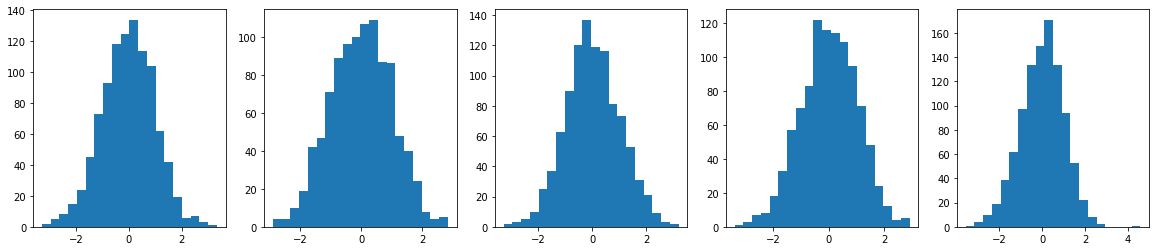

In [21]:
bins=20
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axs):
  ax.hist(X_train[:, i], bins=bins)

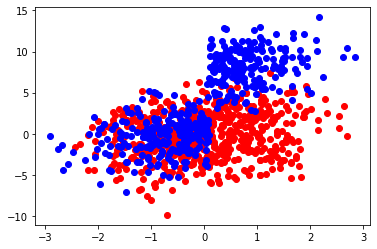

In [22]:
id = 1
plt.scatter(X_train[t_train==0, id], y_train[t_train==0], c='red')
plt.scatter(X_train[t_train==1, id], y_train[t_train==1], c='blue')

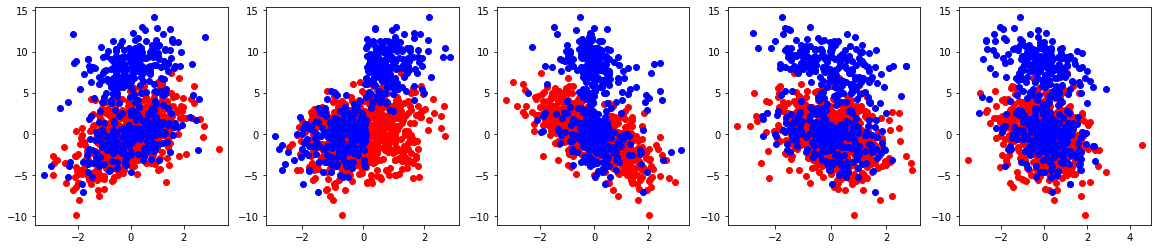

In [20]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axs):
  ax.scatter(X_train[t_train==0, i], y_train[t_train==0], c='red')
  ax.scatter(X_train[t_train==1, i], y_train[t_train==1], c='blue')

## Step 4 - classic perspective

We are going to use the following two approaches:
- Linear models.
- Linear models with IPSW.

### Linear models

In [24]:
lr = LinearRegression()

# Train on the training data.
# In the supervised setting, our usual X here consists of X and T.
# The target is Y - the outcome.
# Input: [X, T], output: Y.
Xt_train = np.hstack([X_train, t_train.reshape(-1, 1)])
lr.fit(Xt_train, y_train)

# Predictions
# Note we set T to a specific value for ALL individuals.
# These are interventional distributions - P(Y|X, do(T=t)).

# Predict Y_0 given [X, 0]
t0 = np.zeros((X_test.shape[0], 1))
Xt0_test = np.hstack([X_test, t0])
y0_pred = lr.predict(Xt0_test)

# Predict Y_1 given [X, 1]
t1 = np.ones((X_test.shape[0], 1))
Xt1_test = np.hstack([X_test, t1])
y1_pred = lr.predict(Xt1_test)

# CATE = Y_1 - Y_0
lr_te = y1_pred - y0_pred

In [25]:
lr_ate = ate_error(lr_te, expected_te)
lr_pehe = pehe_error(lr_te, expected_te)

print(lr_ate)
print(lr_pehe)

0.009541015981409107
3.996810106946033


### Linear models with IPSW

IPW forluma:

$$w_i = \frac{t_i}{P(t_i|x_i)} + \frac{1-t_i}{1-P(t_i|x_i)}$$

In [26]:
def get_ps_weights(clf, x, t):
  ti = np.squeeze(t)
  clf.fit(x, ti)
  ptx = clf.predict_proba(x).T[1].T + 0.0001
  return ti / ptx + ((1.0 - ti) / (1.0 - ptx))

In [30]:
ex = LogisticRegression()
weights = get_ps_weights(ex, X_train, t_train)

lr_ipw = LinearRegression()
lr_ipw.fit(Xt_train, y_train, sample_weight=weights)

# Predict Y_0 given [X, 0]
y0_pred = lr_ipw.predict(Xt0_test)

# Predict Y_1 given [X, 1]
y1_pred = lr_ipw.predict(Xt1_test)

# CATE = Y_1 - Y_0
lr_ipw_te = y1_pred - y0_pred

In [31]:
lr_ipw_ate = ate_error(lr_ipw_te, expected_te)
lr_ipw_pehe = pehe_error(lr_ipw_te, expected_te)

print(lr_ipw_ate)
print(lr_ipw_pehe)

0.03696191195716647
3.9969696249703386


So far we have

In [29]:
results = []
results.append(['LR', lr_ate, lr_pehe])
results.append(['LR (IPW)', lr_ipw_ate, lr_ipw_pehe])

cols = ['Method', 'ATE', 'PEHE']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE,PEHE
0,LR,0.009541,3.99681
1,LR (IPW),0.036962,3.99697


## Step 5 - training

We are going to use three estimators here:
- Random forest (RF; regressor).
- Random forest with Inverse Propensity Weighting (IPW).
- X-learner with RF as base learners.

### Random Forest

#### Description

With random forests we simply model $P(Y|X, T)$, that is, we regress Y on X and T. Once trained, the model predicts potential outcomes $\hat{y}_t^{(i)}$. Thus, to obtain ITE predictions for each individual, we need to predict both $\hat{y}_0$ and $\hat{y}_1$, that is, predict the outcomes for both control and treated settings for each individual.

By calculating the difference between the treated and control outcome, we can obtain the effect per given individual. In other words:

$$\widehat{ITE}^{(i)} = \hat{y}_1^{(i)} - \hat{y}_0^{(i)}$$

#### Usage

In [32]:
# Random Forest
rf = RandomForestRegressor()
rf.fit(Xt_train, y_train)

# Predict Y_0 given [X, 0]
y0_pred = rf.predict(Xt0_test)

# Predict Y_1 given [X, 1]
y1_pred = rf.predict(Xt1_test)

# CATE = Y_1 - Y_0
rf_te = y1_pred - y0_pred

In [34]:
rf_ate = ate_error(rf_te, expected_te)
rf_pehe = pehe_error(rf_te, expected_te)

print(rf_ate)
print(rf_pehe)

0.17272292596842753
0.6670966421868239


### Random Forest with IPW

#### Description

This is a similar approach to the previous one, but extends it further with the Inverse Propensity Weighting (IPW). We proceed as follows:

1. Use random forest classifier to model unit's probability of receiving the treatment, that is, $P(t_i|x_i)$. Input: X, target: T. Note this is classic binary classification problem. $P(t_i|x_i)$ is called a **propensity score**.
2. Use trained classifier to predict propensity scores for each individual. Compute weights per each sample as:

$$w_i = \frac{t_i}{P(t_i|x_i)} + \frac{1-t_i}{1-P(t_i|x_i)}$$

Intuition: Dominant group gets smaller weights. In practice, gives more importance to treated samples.

3. Use sample weights in random forest regressor training.
4. Proceed with predictions as in the previous section.

We can compute the sample weights with the following function:

In [ ]:
def get_ps_weights(clf, x, t):
  ti = np.squeeze(t)
  clf.fit(x, ti)
  ptx = clf.predict_proba(x).T[1].T + 0.0001
  return ti / ptx + ((1.0 - ti) / (1.0 - ptx))

#### Usage

In [36]:
# Get the sample weights
ex_rf = RandomForestClassifier()
weights = get_ps_weights(ex_rf, X_train, t_train)

# Random Forest
rf_ipw = RandomForestRegressor()
rf_ipw.fit(Xt_train, y_train, sample_weight=weights)

# Predict Y_0 given [X, 0]
y0_pred = rf_ipw.predict(Xt0_test)

# Predict Y_1 given [X, 1]
y1_pred = rf_ipw.predict(Xt1_test)

# CATE = Y_1 - Y_0
rf_ipw_te = y1_pred - y0_pred

In [37]:
rf_ipw_ate = ate_error(rf_ipw_te, expected_te)
rf_ipw_pehe = pehe_error(rf_ipw_te, expected_te)

print(rf_ipw_ate)
print(rf_ipw_pehe)

0.16432729257813383
0.698105162600635


### Doubly Robust

#### Formal description

#### Usage

In [42]:
dr = DRLearner(model_propensity=RandomForestClassifier(), model_regression=RandomForestRegressor(), model_final=RandomForestRegressor(), cv=5)
dr.fit(y_train, t_train, X=X_train)

dr_te = dr.effect(X_test)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [43]:
dr_ate = ate_error(dr_te, expected_te)
dr_pehe = pehe_error(dr_te, expected_te)

print(dr_ate)
print(dr_pehe)

0.2690703169176496
1.3407489037460936


### X-learner

#### Formal description

A meta-learner implemented via EconML. Uses provided regressors and classifiers to solve smaller sub-problems. Models the effect directly instead of the outcomes, predicting ITEs as a consequence.

Originally introduced in [(Künzel et al. 2019)](http://arxiv.org/abs/1706.03461). The modelling process of the X-learner can be divided into three stages.

**Stage 1**

Use provided regressors to model $\mathcal{Y}_0$ and $\mathcal{Y}_1$ separately. More formally, the response functions are:

$$\mu_0(x) = \mathbb{E}[\mathcal{Y}_0|X=x]$$
$$\mu_1(x) = \mathbb{E}[\mathcal{Y}_1|X=x]$$

We denote estimated functions as $\hat{\mu}_0$ and $\hat{\mu}_1$.

**Stage 2**

Define imputed treatment effects as:

$$\mathcal{D}_0^{(i)} = \hat{\mu}_1(X_0^{(i)}) - \mathcal{Y}_0^{(i)}$$
$$\mathcal{D}_1^{(i)} = \mathcal{Y}_1^{(i)} - \hat{\mu}_0(X_1^{(i)})$$

Use provided regressors to model $\mathcal{D}_0$ and $\mathcal{D}_1$ separately. The response functions are formally defined as:

$$\tau_0(x) = \mathbb{E}[\mathcal{D}_0|X=x]$$
$$\tau_1(x) = \mathbb{E}[\mathcal{D}_1|X=x]$$

We denote estimated functions as $\hat{\tau}_0$ and $\hat{\tau}_1$.

**Stage 3**

The final treatment effect estimate is a weighted average of the two estimates from Stage 2:

$$\hat{\tau}(x) = g(x)\hat{\tau}_0(x) + (1 - g(x))\hat{\tau}_1(x)$$

Where $g \in [0, 1]$ is a weight function. In practice, $g$ can be modelled as a propensity score function $e$, formally written as:

$$e(x) = \mathbb{E}[T|X=x]$$

Using a provided classifier, we can obtain an estimate $\hat{e}$ that can be used in place of $g$. That is:

$$\hat{\tau}(x) = \hat{e}(x)\hat{\tau}_0(x) + (1 - \hat{e}(x))\hat{\tau}_1(x)$$

In summary, we perform the following steps:
1. Training (inputs: X, T, Y; outputs: $\hat{\tau}_0$, $\hat{\tau}_1$, $\hat{e}$):
  1. Model the outcomes with a provided regressor class and obtain estimators $\hat{\mu}_0$ and $\hat{\mu}_1$.
  2. Make predictions $\hat{\mu}_1(X_0^{(i)})$ and $\hat{\mu}_0(X_1^{(i)})$.
  3. Compute imputed treatment effects $\mathcal{D}_0$ and $\mathcal{D}_1$.
  4. Model the imputed treatment effects with a provided regressor class and obtain estimators $\hat{\tau}_0$ and $\hat{\tau}_1$.
  5. Model the propensity scores with a provided classifier class and obtain an estimator $\hat{e}$.
2. Prediction (inputs: X; outputs: $\widehat{ITE}$):
  1. Use estimator $\hat{\tau}$ to obtain individual treatment effect estimates.

#### Usage

We continue with random forests here by providing the X-learner with RF regressor and RF classifier as base learners. Note it distinguishes X from T in its input - it is necessary to learn the propensity score estimator. Also, the final prediction does not depend on T! Though it does indirectly by predicting the propensity score internally.

In [44]:
# X-Learner
xl = XLearner(models=RandomForestRegressor(), propensity_model=RandomForestClassifier())
xl.fit(y_train, t_train, X=X_train)

xl_te = xl.effect(X_test)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [45]:
xl_ate = ate_error(xl_te, expected_te)
xl_pehe = pehe_error(xl_te, expected_te)

print(xl_ate)
print(xl_pehe)

0.09187998471715542
0.5221268174176237


## Step 6 - evaluation

We will examine our estimators' performance from different perspectives:
- ATE and PEHE errors
- Visualisations of predicted effects

### Causal metrics

In [46]:
results = []
results.append(['LR', lr_ate, lr_pehe])
results.append(['LR (IPW)', lr_ipw_ate, lr_ipw_pehe])
results.append(['RF', rf_ate, rf_pehe])
results.append(['RF (IPW)', rf_ipw_ate, rf_ipw_pehe])
results.append(['DR', dr_ate, dr_pehe])
results.append(['XL', xl_ate, xl_pehe])

cols = ['Method', 'ATE', 'PEHE']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE,PEHE
0,LR,0.009541,3.996810
1,LR (IPW),0.036962,3.996970
2,RF,0.172723,0.667097
3,RF (IPW),0.164327,0.698105
4,DR,0.269070,1.340749
5,XL,0.091880,0.522127


### Visual comparisons

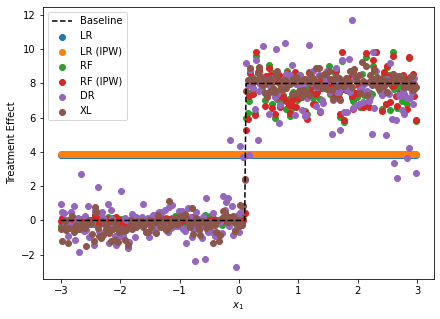

In [54]:
id = 1

plt.figure(figsize=(7, 5))
plt.plot(X_test[:, id], expected_te, color='black', ls='--', label='Baseline')
plt.scatter(X_test[:, id], lr_te, label="LR")
plt.scatter(X_test[:, id], lr_ipw_te, label="LR (IPW)")
plt.scatter(X_test[:, id], rf_te, label="RF")
plt.scatter(X_test[:, id], rf_ipw_te, label="RF (IPW)")
plt.scatter(X_test[:, id], dr_te, label="DR")
plt.scatter(X_test[:, id], xl_te, label="XL")
plt.xlabel(f'$x_{id}$')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

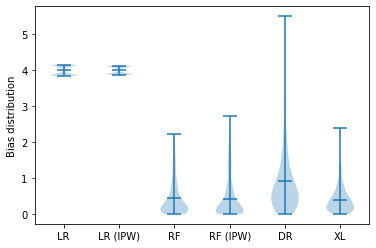

In [55]:
plt.violinplot([np.abs(lr_te - expected_te), 
                np.abs(lr_ipw_te - expected_te),
                np.abs(rf_te - expected_te),
                np.abs(rf_ipw_te - expected_te),
                np.abs(dr_te - expected_te),
                np.abs(xl_te - expected_te)
               ], showmeans=True)
plt.ylabel("Bias distribution")
plt.xticks([1, 2, 3, 4, 5, 6], ['LR', 'LR (IPW)', 'RF', 'RF (IPW)', 'DR', 'XL'])
plt.show()

## (optional) Hyperparameter tuning?